In [18]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# loop over the list of csv files
products  = ["XLB","XLE","XLF","XLI","XLK","XLP","XLY","XLV","XRT","XTL"] # ,asofdate,pnl,strategy,positionType,position_identifier
merge_lst = []

path      = os.getcwd()
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
for product in products:
    
    for f in csv_files:
        if product+"_pnl" in f:
            pnl_df = pd.read_csv(f)      
            pnl_df['product_name'] = [product]*len(pnl_df)     

            close_df = pd.read_csv(product+'.csv')

            result = pd.merge(close_df[['Date','Close','Dividends','Stock Splits']], 
                            pnl_df[['asofdate', 'pnl','strategy','positionType','position_identifier']],
                            left_on='Date',
                            right_on='asofdate',
                            how='inner')

            merge_lst.append(result)

merge_df = pd.concat(merge_lst,axis=0).reset_index()

# saving the position ticker
cache_position_ticker = []

i = 0
while i < len(merge_df):

    cache_position_ticker.append(merge_df['position_identifier'][i].split("_")[0])

    i+=1

merge_df['product_name'] = cache_position_ticker

# save the position entry date

merge_df['position_identifier'].unique()

start_date = []

for position in merge_df['position_identifier'].unique():

    date = merge_df[merge_df['position_identifier'] == position].reset_index()['Date'][0]

    i = 0
    while i < len(merge_df[merge_df['position_identifier'] == position]):

        start_date.append(date)    

        i+=1

merge_df['entry_date'] = start_date

merge_df.reset_index()

,level_0,index,Date,Close,Dividends,Stock Splits,asofdate,pnl,strategy,positionType,position_identifier,product_name,entry_date
0,0,0,2014-05-13 00:00:00-04:00,40.324615,0.0,0.0,2014-05-13 00:00:00-04:00,0.508224,arma_ma,long,XLB_long_0,XLB,2014-05-13 00:00:00-04:00
1,1,1,2014-05-14 00:00:00-04:00,40.332935,0.0,0.0,2014-05-14 00:00:00-04:00,0.033333,arma_ma,long,XLB_long_0,XLB,2014-05-13 00:00:00-04:00
2,2,2,2014-05-15 00:00:00-04:00,39.766392,0.0,0.0,2014-05-15 00:00:00-04:00,0.008320,arma_ma,long,XLB_long_0,XLB,2014-05-13 00:00:00-04:00
3,3,3,2014-05-16 00:00:00-04:00,39.908035,0.0,0.0,2014-05-16 00:00:00-04:00,-0.566544,arma_ma,long,XLB_long_0,XLB,2014-05-13 00:00:00-04:00
4,4,4,2014-05-19 00:00:00-04:00,40.074650,0.0,0.0,2014-05-19 00:00:00-04:00,0.141644,arma_ma,long,XLB_long_0,XLB,2014-05-13 00:00:00-04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21645,21645,2160,2022-12-08 00:00:00-05:00,84.677643,0.0,0.0,2022-12-08 00:00:00-05:00,0.000000,arma_ma,no_position,XTL_no_position_2160,XTL,2022-12-08 00:00:00-05:00
21646,21646,2161,2022-12-09 00:00:00-05:00,83.640244,0.0,0.0,2022-12-09 00:00:00-05:00,0.000000,arma_ma,no_position,XTL_no_position_2160,XTL,2022-12-08 00:00:00-05:00
21647,21647,2162,2022-12-12 00:00:00-05:00,84.587868,0.0,0.0,2022-12-12 00:00:00-05:00,0.000000,arma_ma,no_position,XTL_no_position_2160,XTL,2022-12-08 00:00:00-05:00
21648,21648,2163,2022-12-13 00:00:00-05:00,85.006813,0.0,0.0,2022-12-13 00:00:00-05:00,0.000000,arma_ma,no_position,XTL_no_position_2160,XTL,2022-12-08 00:00:00-05:00


In [19]:
products  = ["IYR","XLB","XLE","XLF","XLI","XLK","XLP","XLU","XLV","XOP","XRT","XTL"] 

portfolio_value = 100000
position_size   = 1/len(products)

hist_portfolio_value = []
position_scaled_df   = []
updated_position_lst = []

for date in merge_df['entry_date'].unique():

    
    position_scaled_df   = []
    # updated_position_lst = []
    for position in  merge_df[merge_df['entry_date'] == date]['position_identifier'].unique():

        position_df = merge_df[(merge_df['position_identifier'] == position)]
        position_df.reset_index(inplace=True)

        scale         = []
        portfolio_lst = []

        i = 0
        while i < len(position_df):

            if position_df['positionType'][i] == 'long':
                scale.append(2*np.floor(portfolio_value*position_size/position_df['Close'][0]))

            if position_df['positionType'][i] == 'short':
                scale.append(np.floor(portfolio_value*position_size/position_df['Close'][0]))

            if position_df['positionType'][i] == 'no_position':
                scale.append(np.floor(portfolio_value*position_size/position_df['Close'][0]))

            portfolio_lst.append(portfolio_value)

            i+=1

        position_df['scale']           = scale
        position_df['rescaled_pnl']    = position_df['scale']*position_df['pnl']
        position_df['portfolio_value'] = portfolio_lst
 
        position_scaled_df.append(position_df)

    updated_position_df = pd.concat(position_scaled_df,axis = 0)
    portfolio_value     = portfolio_value + updated_position_df['rescaled_pnl'].sum()

    updated_position_lst.append(pd.concat(position_scaled_df,axis = 0))



c:\Users\James Stanley\anaconda3\envs\airflow-env\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\James Stanley\anaconda3\envs\airflow-env\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\James Stanley\anaconda3\envs\airflow-env\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [20]:
portfolio_df = pd.concat(updated_position_lst,axis=0)

In [21]:
test_df = portfolio_df.groupby('Date').sum()

In [22]:
test_df['rescaled_pnl'].cumsum()

Date
2014-05-13 00:00:00-04:00    9.707511e+02
2014-05-14 00:00:00-04:00    1.101224e+03
2014-05-15 00:00:00-04:00    7.017721e+02
2014-05-16 00:00:00-04:00   -2.990396e+02
2014-05-19 00:00:00-04:00   -3.427008e+01
                                 ...     
2022-12-08 00:00:00-05:00    1.431524e+06
2022-12-09 00:00:00-05:00    1.432583e+06
2022-12-12 00:00:00-05:00    1.429877e+06
2022-12-13 00:00:00-05:00    1.432236e+06
2022-12-14 00:00:00-05:00    1.433019e+06
Name: rescaled_pnl, Length: 2165, dtype: float64

In [23]:
(2952360.5034646997/100000)**(1/8.59) -1

0.48302659437119955

In [24]:
test_df_pnl = test_df['rescaled_pnl'].cumsum()

In [25]:
test_df_pnl.to_csv(r'final_pnl.csv')

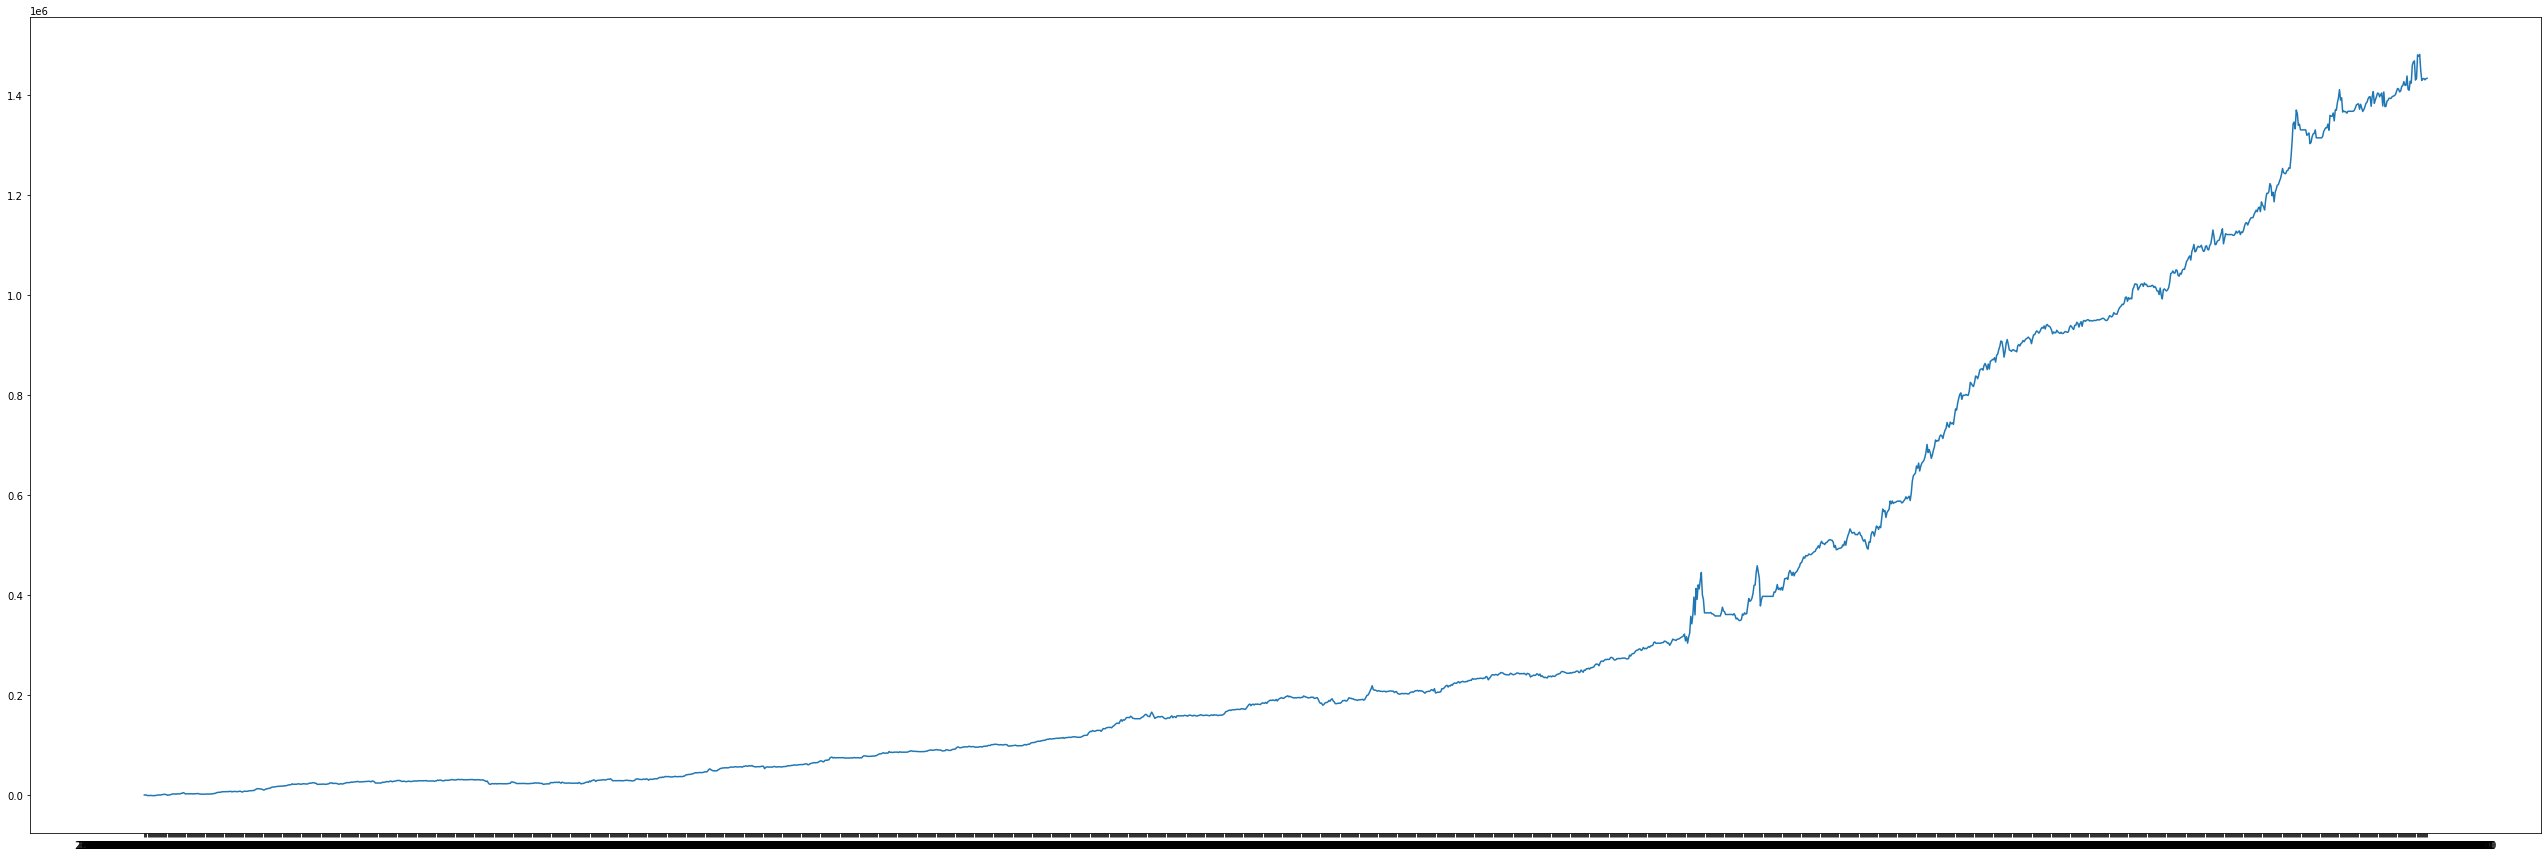

In [26]:
plt.figure(figsize=(45,15))

plt.plot(test_df['rescaled_pnl'].cumsum())

plt.show()

In [27]:
drawdown = 100000+ test_df['rescaled_pnl'].cumsum()

In [28]:
drawdown = drawdown/drawdown.rolling(window=252).max()

In [29]:
drawdown.to_csv(r'drawdown.csv')

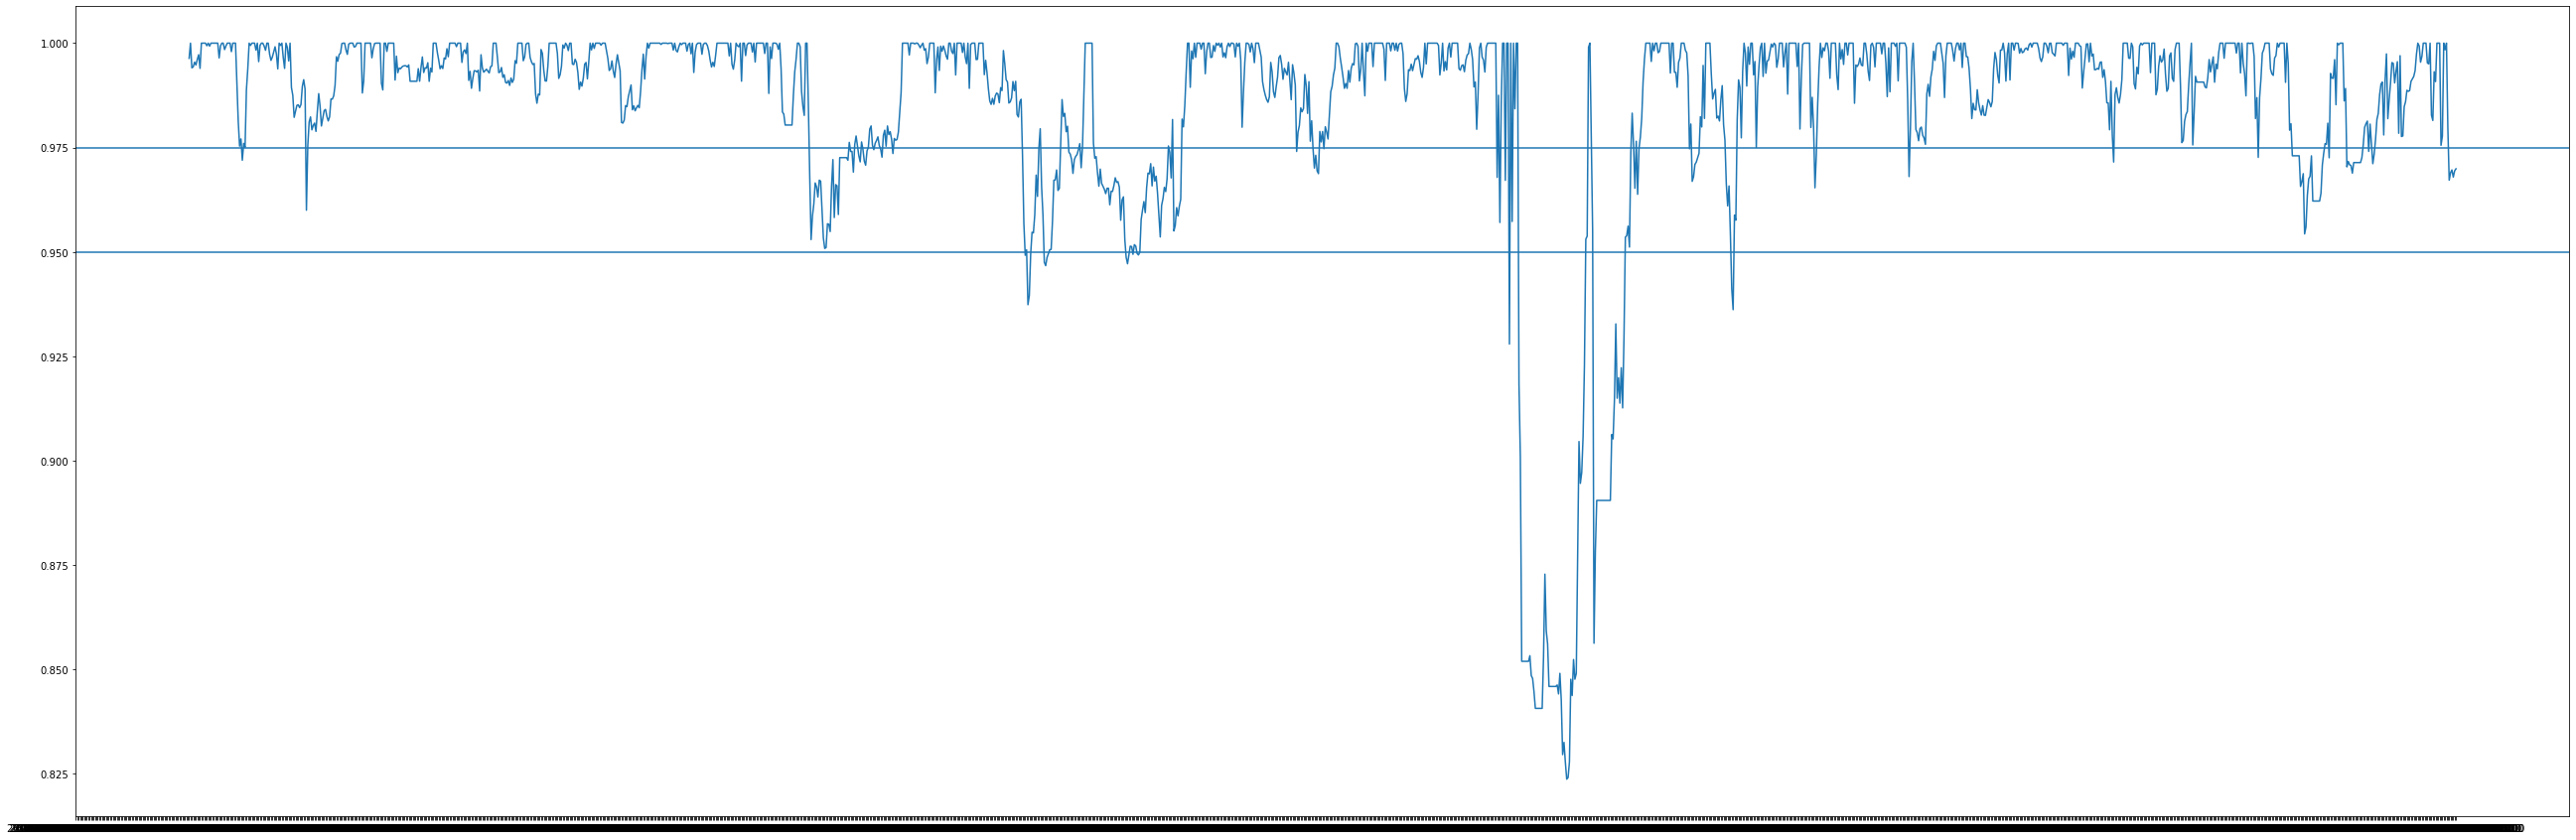

In [30]:
plt.figure(figsize=(45,15))

plt.plot(drawdown/drawdown.rolling(window=252).max())
plt.axhline(0.95)
plt.axhline(0.975)

plt.show()

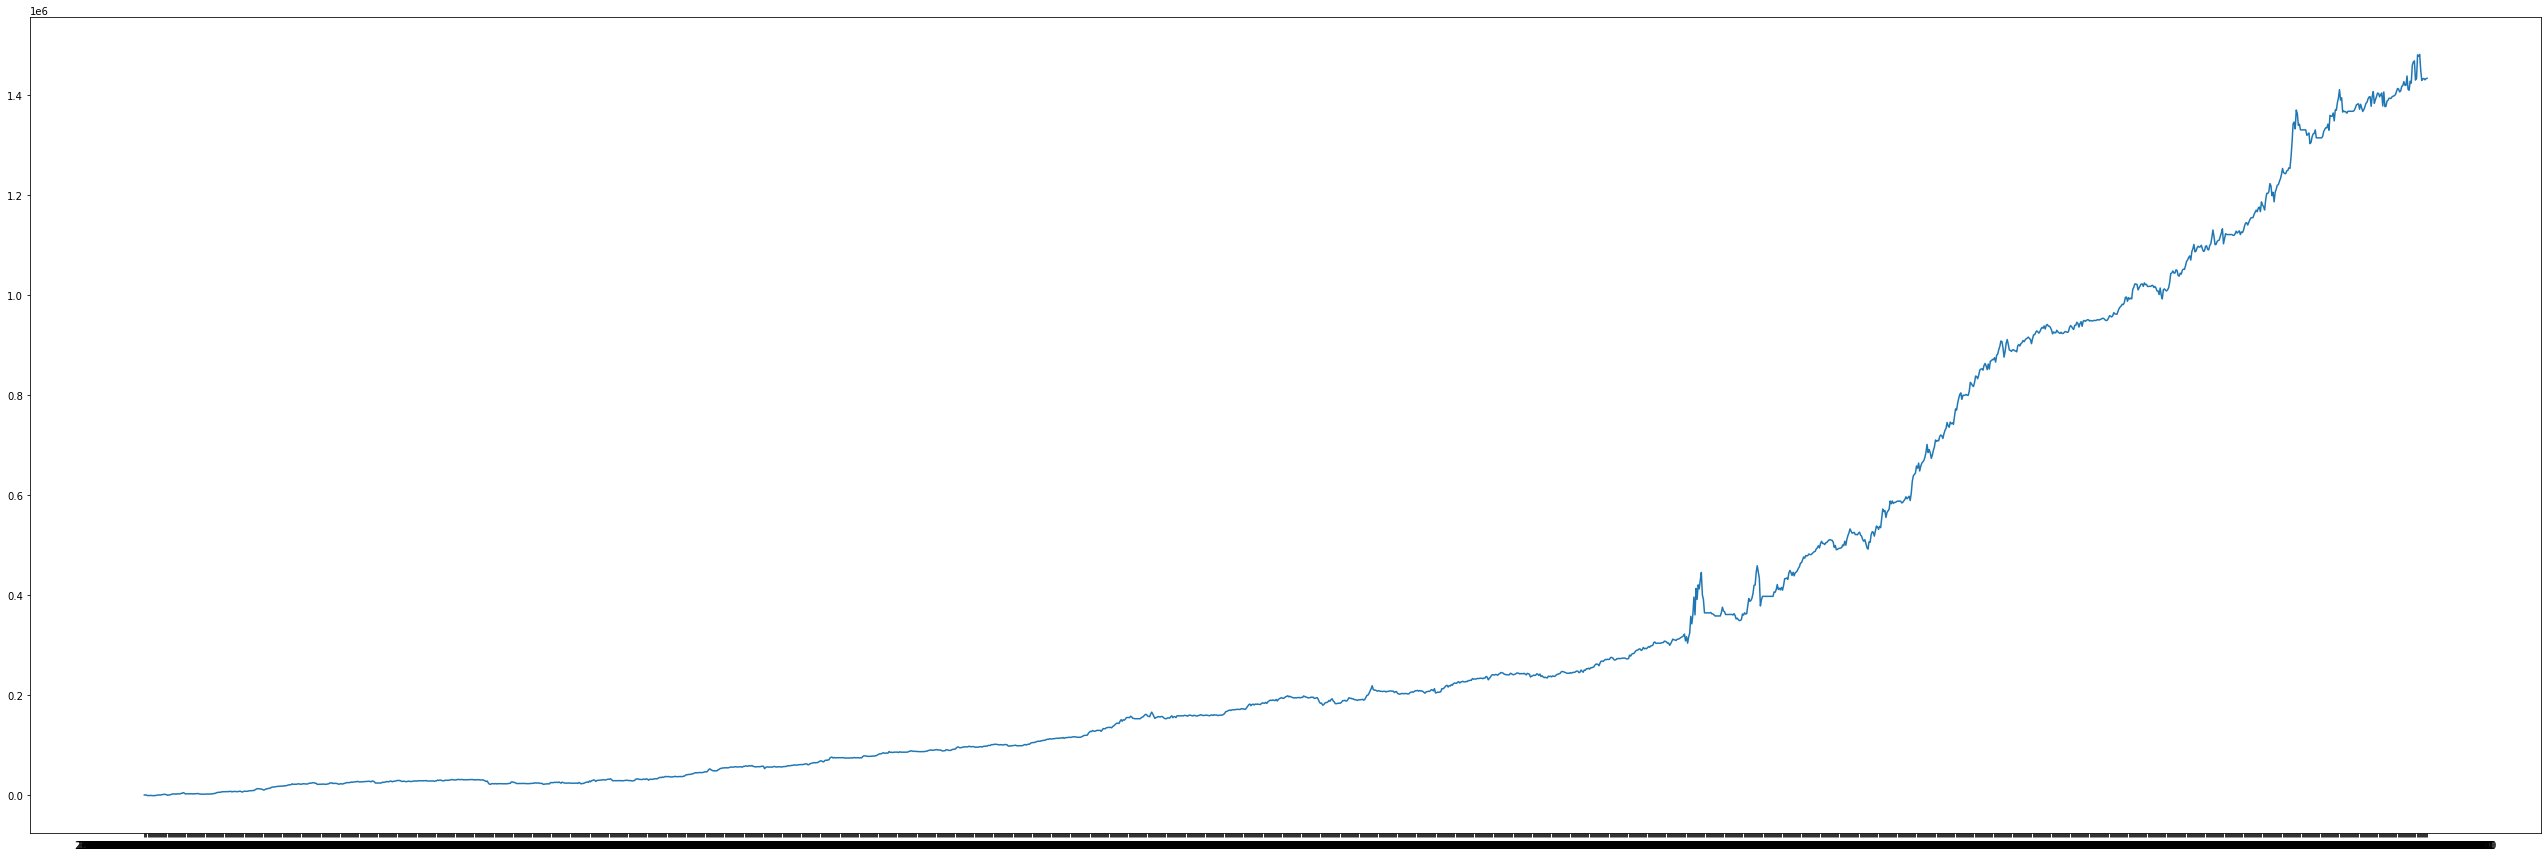

In [31]:
plt.figure(figsize=(45,15))

plt.plot(test_df['rescaled_pnl'].cumsum())

plt.show()

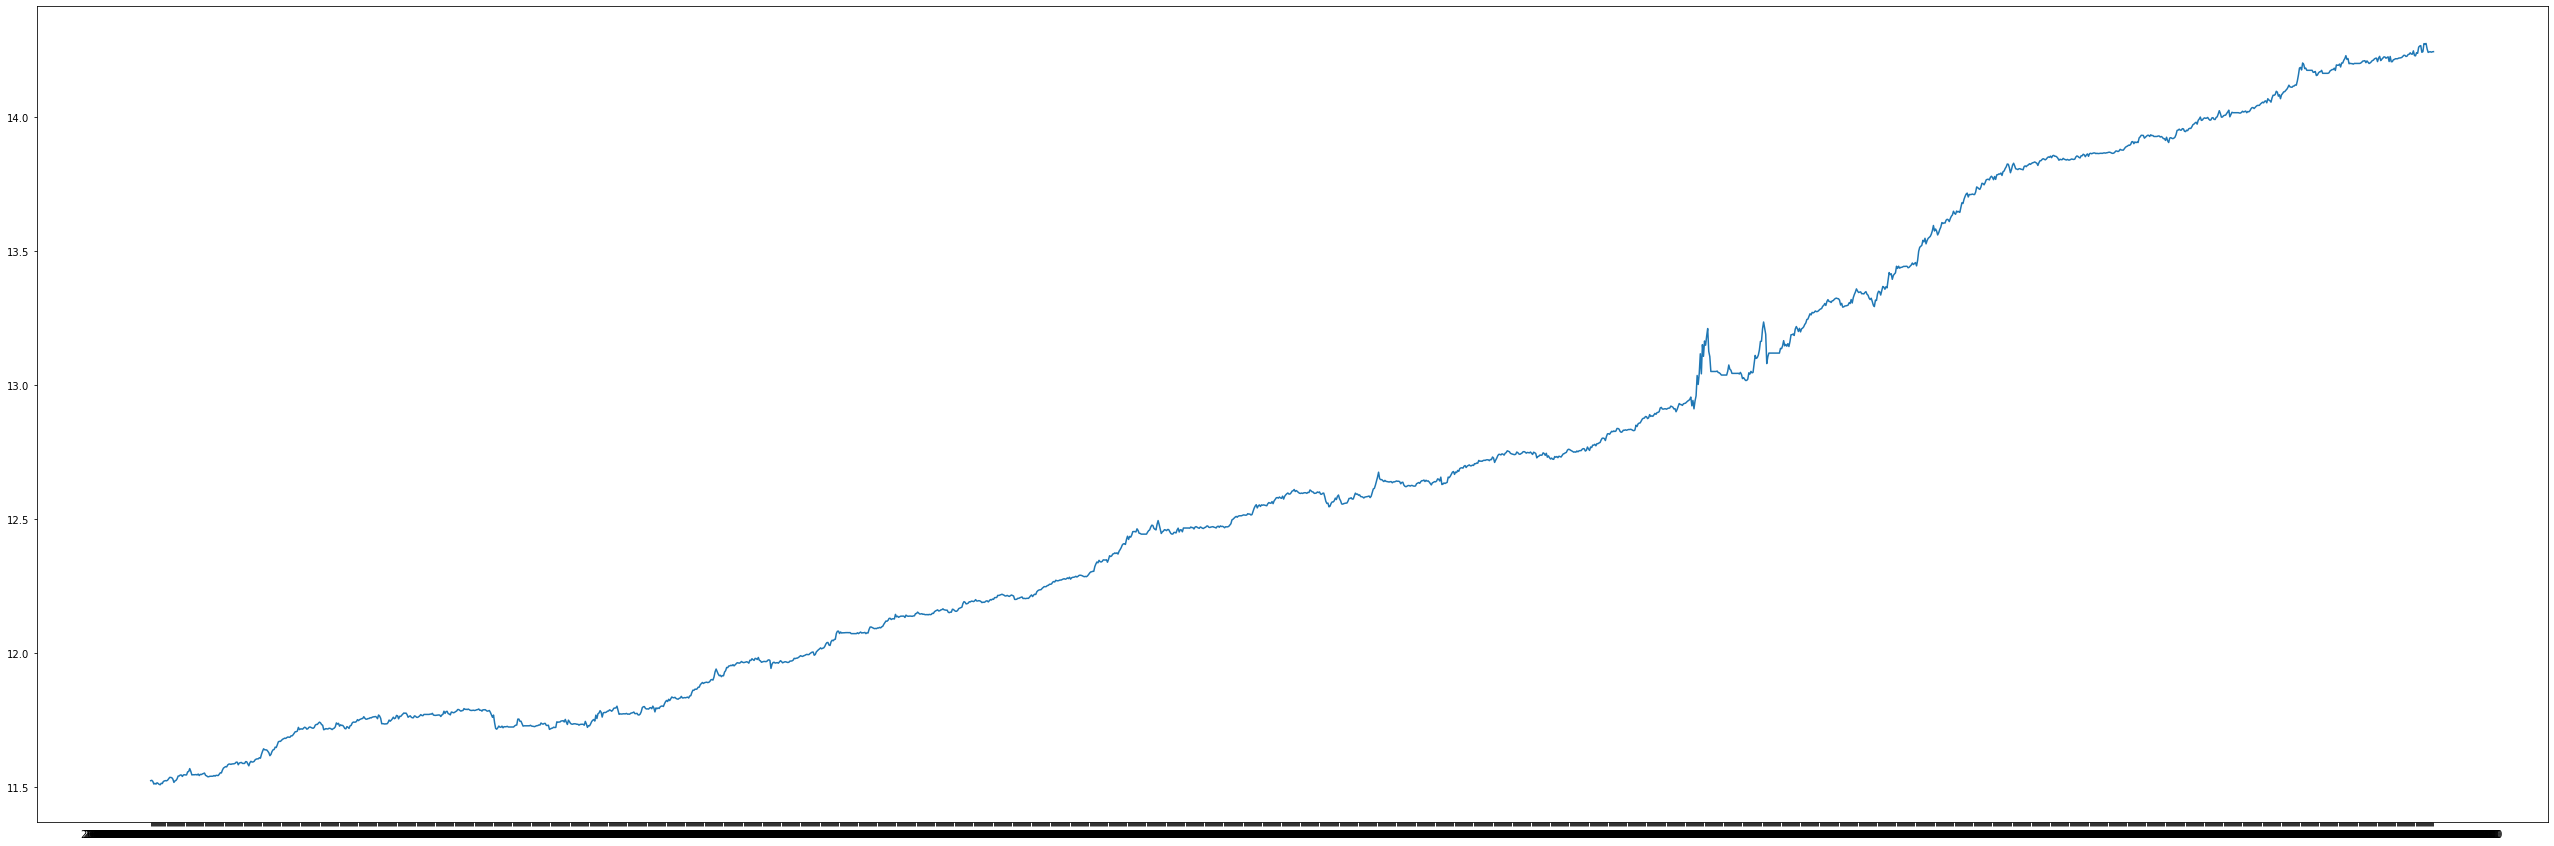

In [32]:
plt.figure(figsize=(45,15))

plt.plot(np.log(100000+test_df['rescaled_pnl'].cumsum()))

plt.show()

In [33]:
test = portfolio_df

In [34]:
test.set_index('Date',inplace=True)

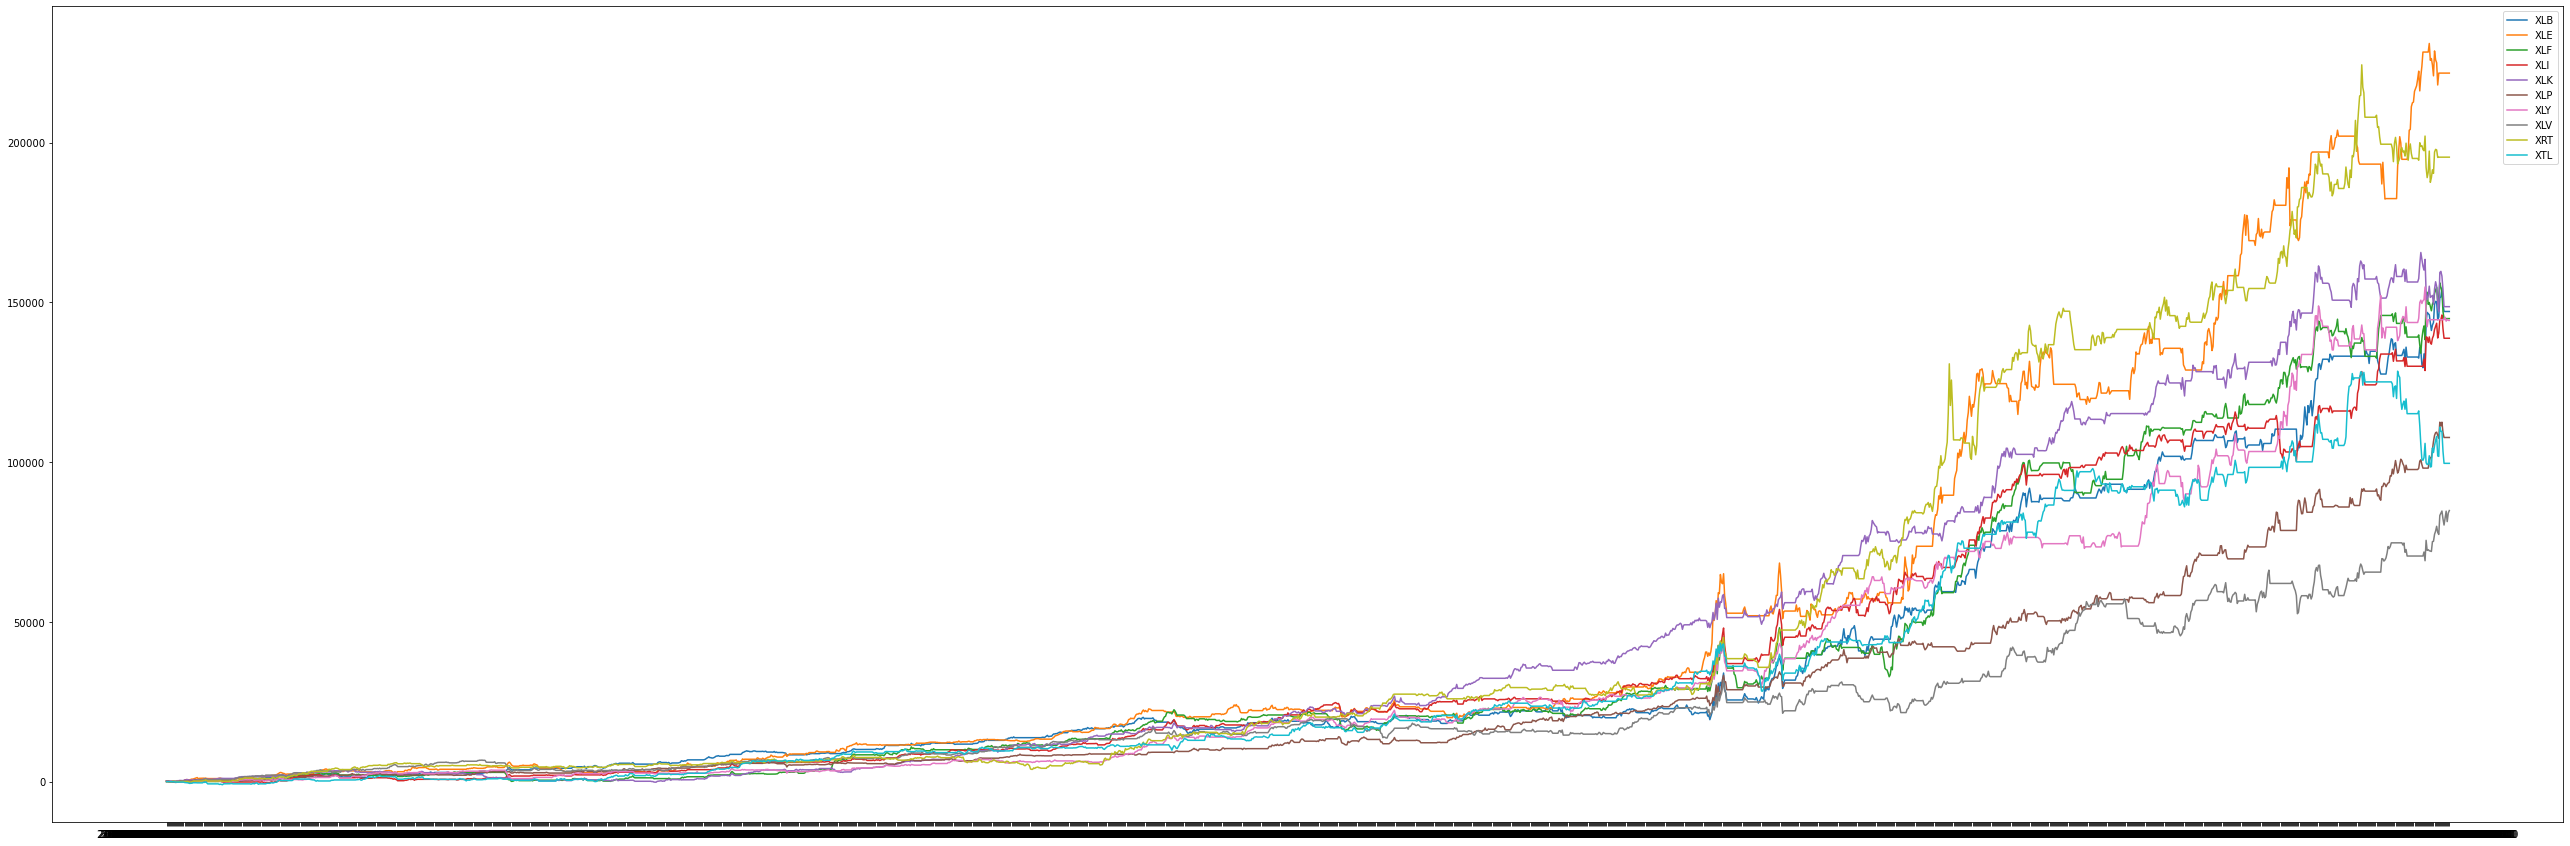

In [35]:
plt.figure(figsize=(45,15))

for product in portfolio_df['product_name'].unique():
    plt.plot(test[test['product_name'] == product]['rescaled_pnl'].cumsum())

plt.legend(test['product_name'].unique())
plt.show()

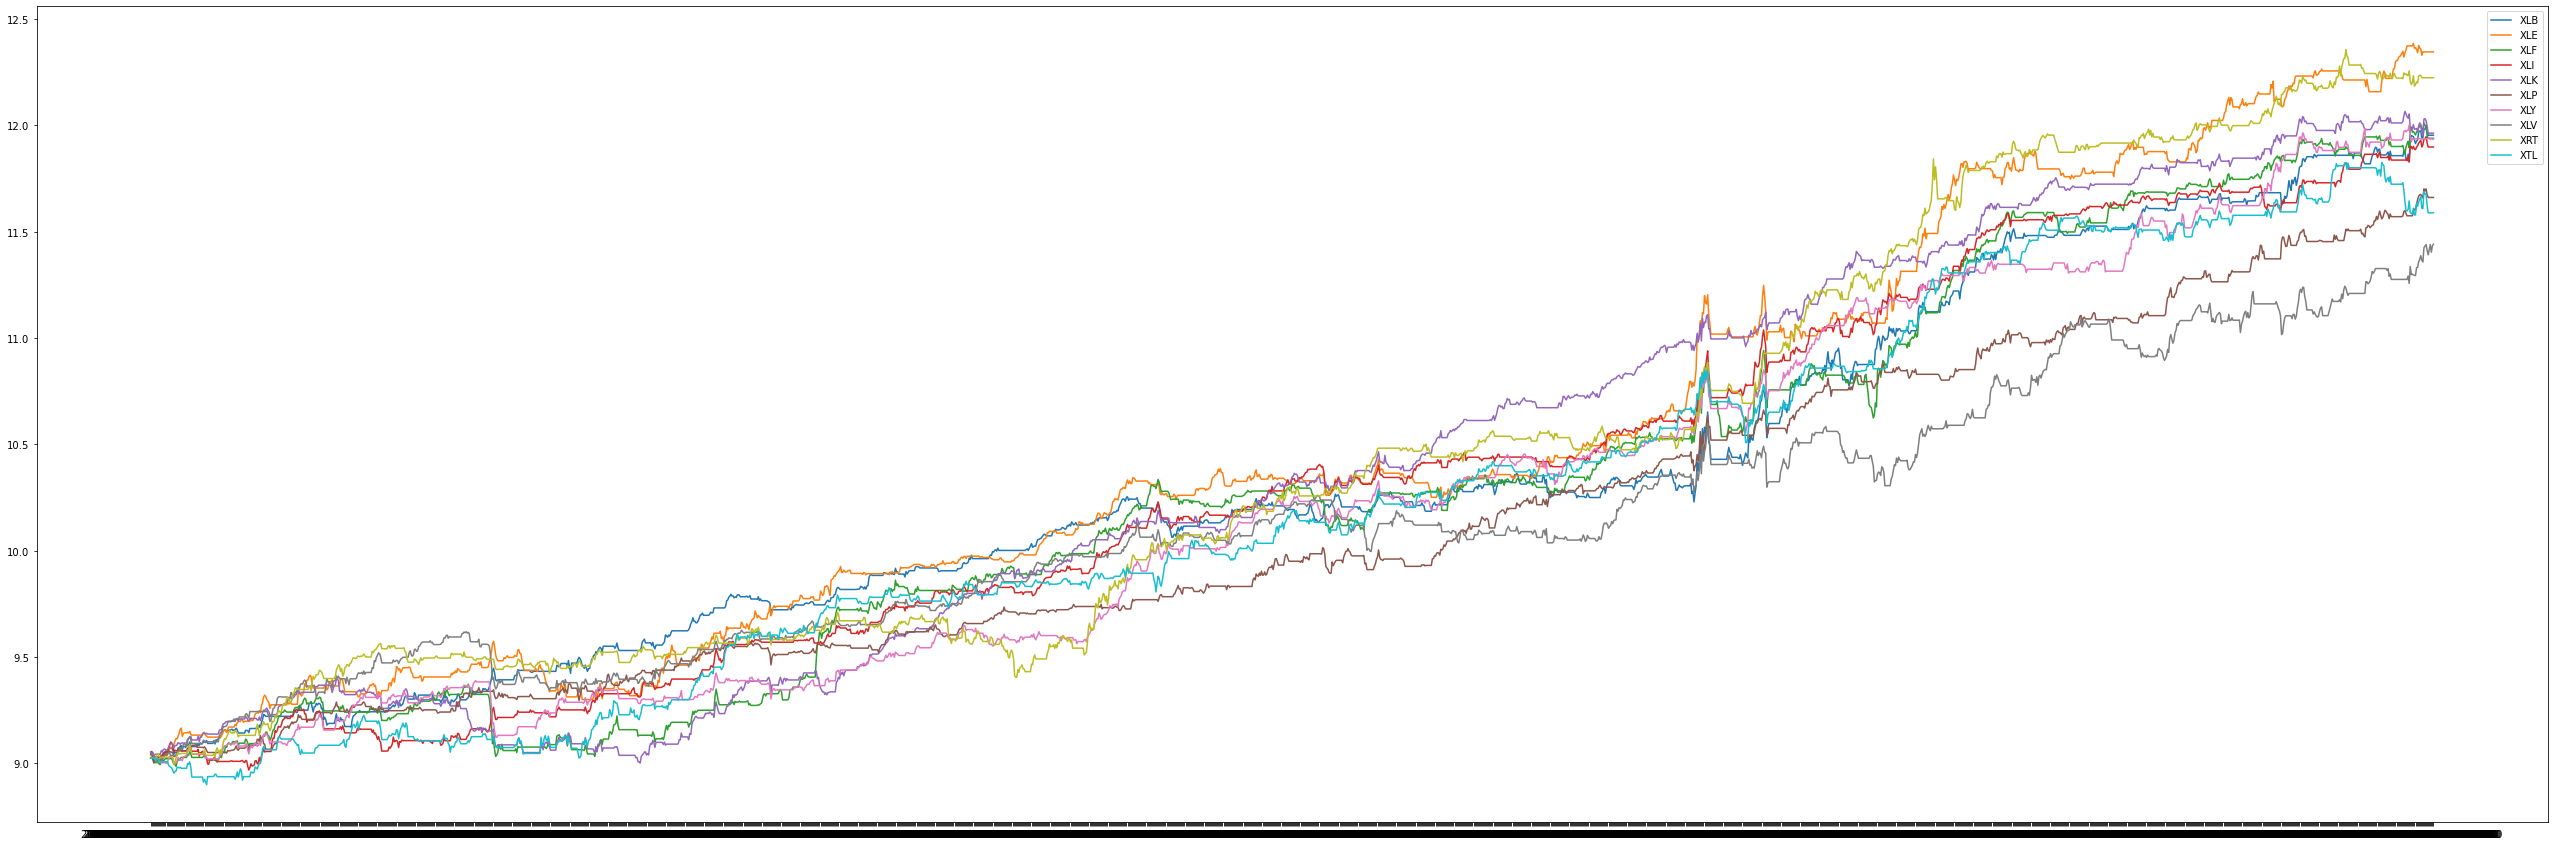

In [36]:
plt.figure(figsize=(45,15))

for product in portfolio_df['product_name'].unique():
    plt.plot(np.log(8300+test[test['product_name'] == product]['rescaled_pnl'].cumsum()))

plt.legend(test['product_name'].unique())
plt.show()

In [37]:
summary_df = portfolio_df.groupby('Date')

In [38]:
summary_df.to_csv(r'summary.csv')

AttributeError: 'DataFrameGroupBy' object has no attribute 'to_csv'

In [ ]:
summary_df.head()

,level_0,index,Date,Close,Dividends,Stock Splits,asofdate,pnl,strategy,positionType,position_identifier,product_name,entry_date,scale,rescaled_pnl
0,0,0,2019-05-15 00:00:00-04:00,78.588486,0.0,0.0,2019-05-15 00:00:00-04:00,0.322548,arma_ma,long,IYR_long_0,IYR,2019-05-15 00:00:00-04:00,318.0,102.570236
1,1,1,2019-05-16 00:00:00-04:00,79.054413,0.0,0.0,2019-05-16 00:00:00-04:00,0.510727,arma_ma,long,IYR_long_0,IYR,2019-05-15 00:00:00-04:00,318.0,162.411163
2,2,2,2019-05-17 00:00:00-04:00,78.830399,0.0,0.0,2019-05-17 00:00:00-04:00,0.465927,arma_ma,long,IYR_long_0,IYR,2019-05-15 00:00:00-04:00,318.0,148.164825
3,3,3,2019-05-20 00:00:00-04:00,77.665596,0.0,0.0,2019-05-20 00:00:00-04:00,-0.224014,arma_ma,long,IYR_long_0,IYR,2019-05-15 00:00:00-04:00,318.0,-71.236542
4,4,4,2019-05-21 00:00:00-04:00,78.319695,0.0,0.0,2019-05-21 00:00:00-04:00,-1.164803,arma_ma,long,IYR_long_0,IYR,2019-05-15 00:00:00-04:00,318.0,-370.407211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,4520,900,2022-12-08 00:00:00-05:00,99.009277,0.0,0.0,2022-12-08 00:00:00-05:00,0.000000,arma_ma,no_position,XLI_no_position_900,XLI,2022-12-08 00:00:00-05:00,10729.0,0.000000
1,4521,901,2022-12-09 00:00:00-05:00,98.196510,0.0,0.0,2022-12-09 00:00:00-05:00,0.000000,arma_ma,no_position,XLI_no_position_900,XLI,2022-12-08 00:00:00-05:00,10729.0,0.000000
2,4522,902,2022-12-12 00:00:00-05:00,99.881516,0.0,0.0,2022-12-12 00:00:00-05:00,0.000000,arma_ma,no_position,XLI_no_position_900,XLI,2022-12-08 00:00:00-05:00,10729.0,0.000000
3,4523,903,2022-12-13 00:00:00-05:00,100.258163,0.0,0.0,2022-12-13 00:00:00-05:00,0.000000,arma_ma,no_position,XLI_no_position_900,XLI,2022-12-08 00:00:00-05:00,10729.0,0.000000


In [ ]:
merge_df['scale']        = scale
merge_df['rescaled_pnl'] = merge_df['scale']*merge_df['pnl']

merge_df['cumulative_pnl'] = merge_df.groupby(by='Date')['rescaled_pnl'].sum()

In [ ]:
portfolio_value = 100000
position_size   = 1/len(products)

scale = []

merge_df = merge_df.reset_index()

i = 0
while i < len(merge_df):
    
    if merge_df['positionType'][i] == 'long':
        scale.append(3*np.floor(portfolio_value*position_size/merge_df['Close'][i]))

    if merge_df['positionType'][i] == 'short':
        scale.append(np.floor(portfolio_value*position_size/merge_df['Close'][i]))

    if merge_df['positionType'][i] == 'no_position':
        scale.append(np.floor(portfolio_value*position_size/merge_df['Close'][i]))
        
    i+=1

merge_df['scale']        = scale
merge_df['rescaled_pnl'] = merge_df['scale']*merge_df['pnl']

merge_df['cumulative_pnl'] = merge_df.groupby(by='Date')['rescaled_pnl'].sum()